In [1]:
# Import Librarires

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import os, re, glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import itertools

import fitz  
from lxml import etree

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                           accuracy_score, precision_score, recall_score, 
                           roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from difflib import SequenceMatcher

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("plotly not available - using matplotlib only")

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("wordcloud not available")

np.random.seed(42)

plotly not available - using matplotlib only
wordcloud not available


Configuration & Data

In [4]:
INPUT_DIR = r"D:/AI ML ICBT/make-data-count-finding-data-references" 

def load_data_files(input_dir: str):
    test_pdf = sorted(glob.glob(os.path.join(input_dir, "test", "PDF", "*.pdf")))
    test_xml = sorted(glob.glob(os.path.join(input_dir, "test", "XML", "*.xml")))
    print("Data Loading Summary")
    print(f"   • Test PDFs: {len(test_pdf)}")
    print(f"   • Test XMLs: {len(test_xml)}")
    return test_pdf, test_xml

test_pdf, test_xml = load_data_files(INPUT_DIR)

Data Loading Summary
   • Test PDFs: 30
   • Test XMLs: 25


ID Extraction Helpers (precompile regex)

In [5]:
DOI_RE   = re.compile(r'10\.\d{4,9}/[-._;()/:A-Z0-9]+', re.I)
ACC_RE   = re.compile(r'(GSE\d+|SRR\d+|PRJNA\d+|EGAD\d+|GEO:\s*GSE\d+)', re.I)

def extract_ids_from_pdf(pdf_path: str):
    try:
        text_chunks = []
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text_chunks.append(page.get_text("text"))
        full_text = "\n".join(text_chunks)
        dois = DOI_RE.findall(full_text)
        accs = ACC_RE.findall(full_text)
        return dois, accs
    except Exception as e:
        print(f" PDF error [{os.path.basename(pdf_path)}]: {e}")
        return [], []

def extract_ids_from_xml(xml_path: str):
    try:
        tree = etree.parse(xml_path)
        xml_text = etree.tostring(tree.getroot(), encoding="unicode")
        dois = DOI_RE.findall(xml_text)
        accs = ACC_RE.findall(xml_text)
        return dois, accs
    except Exception as e:
        print(f" XML error [{os.path.basename(xml_path)}]: {e}")
        return [], []

print(" ID extractors ready")

 ID extractors ready


Enhanced Feature Extractor

In [6]:
class AdvancedFeatureExtractor:
    def __init__(self):
        self.label_encoders = {}
        self._enc_fitted = set()

    @staticmethod
    def _as_str(x):
        return "" if pd.isna(x) else str(x)

    def extract_domain_features(self, dataset_id):
        ds = self._as_str(dataset_id)
        u = ds.upper()
        l = ds.lower()
        is_doi = 1 if ('10.' in ds or 'doi.org' in l) else 0
        is_repo = 1 if any(p in u for p in ('GSE','SRR','PRJNA','EGAD')) else 0
        
        # Enhanced domain features
        features = {
            'is_doi': is_doi,
            'is_repository': is_repo,
            'is_other': 1 - max(is_doi, is_repo),
            'domain_type': 'doi' if is_doi else ('repository' if is_repo else 'other'),
            'id_length': len(ds),
            'num_digits': sum(c.isdigit() for c in ds),
            'num_special_chars': sum(not c.isalnum() for c in ds),
            'has_version': 1 if re.search(r'(?:^|[^a-z0-9])v\d+(?:[^a-z0-9]|$)|version', l) else 0,
            'has_slash': 1 if '/' in ds else 0,
            'has_dot': 1 if '.' in ds else 0,
            'has_underscore': 1 if '_' in ds else 0,
            'alpha_ratio': sum(c.isalpha() for c in ds) / max(len(ds), 1),
            'digit_ratio': sum(c.isdigit() for c in ds) / max(len(ds), 1),
            'uppercase_ratio': sum(c.isupper() for c in ds) / max(len(ds), 1)
        }
        return features

    def extract_prefix(self, s):
        s = self._as_str(s)
        if 'doi.org/' in s:
            try:
                return s.split('doi.org/')[1].split('/')[0]
            except Exception:
                return 'unknown'
        if '_' in s: return s.split('_')[0]
        if '/' in s: return s.split('/')[0]
        return 'unknown' if not s else s[:16]

    def string_similarity(self, a, b):
        return SequenceMatcher(None, self._as_str(a).lower(), self._as_str(b).lower()).ratio()

    def _encode_safe(self, series: pd.Series, name: str):
        series = series.astype(str).fillna('')
        if name not in self.label_encoders:
            le = LabelEncoder()
            vals = series.astype(str)
            le.fit(vals)
            # add an UNK bucket
            le_classes = list(le.classes_)
            if '<<UNK>>' not in le_classes:
                le_classes.append('<<UNK>>')
            le.classes_ = np.array(sorted(set(le_classes)))
            self.label_encoders[name] = le

        le = self.label_encoders[name]
        known = set(le.classes_)
        mapped = series.apply(lambda x: x if x in known else '<<UNK>>')
        return le.transform(mapped)

    def extract_all(self, df: pd.DataFrame):
        if df.empty:
            return df.assign(
                article_prefix_encoded=[],
                dataset_prefix_encoded=[],
                domain_type_encoded=[],
                string_similarity=[],
                is_doi=[], is_repository=[], is_other=[],
                id_length=[], num_digits=[], num_special_chars=[], has_version=[],
                has_slash=[], has_dot=[], has_underscore=[],
                alpha_ratio=[], digit_ratio=[], uppercase_ratio=[]
            )

        df = df.copy()
        df['article_prefix'] = df['article_id'].map(self.extract_prefix)
        df['dataset_prefix'] = df['dataset_id'].map(self.extract_prefix)
        df['string_similarity'] = df.apply(
            lambda r: self.string_similarity(r['article_id'], r['dataset_id']), axis=1
        )

        # domain features
        dom = df['dataset_id'].map(self.extract_domain_features).apply(pd.Series)
        df = pd.concat([df, dom], axis=1)

        # encodings (robust to unseen)
        df['article_prefix_encoded'] = self._encode_safe(df['article_prefix'], 'article_prefix')
        df['dataset_prefix_encoded'] = self._encode_safe(df['dataset_prefix'], 'dataset_prefix')
        df['domain_type_encoded']   = self._encode_safe(df['domain_type'],   'domain_type')

        # final fill
        return df.fillna(0)

print("Enhanced feature extractor ready")

Enhanced feature extractor ready


Build Test Candidates

In [7]:
print("Scanning test files for candidates...")
rows = []
rid = 1

for path in tqdm(test_pdf, desc="PDFs"):
    dois, accs = extract_ids_from_pdf(path)
    aid = os.path.splitext(os.path.basename(path))[0]
    for v in dois + accs:
        rows.append({'row_id': rid, 'article_id': aid, 'dataset_id': v, 'type': None})
        rid += 1

for path in tqdm(test_xml, desc="XMLs"):
    dois, accs = extract_ids_from_xml(path)
    aid = os.path.splitext(os.path.basename(path))[0]
    for v in dois + accs:
        rows.append({'row_id': rid, 'article_id': aid, 'dataset_id': v, 'type': None})
        rid += 1

df_test = pd.DataFrame(rows)
print(f"Extracted {len(df_test)} candidate pairs")

Scanning test files for candidates...


XMLs: 100%|██████████| 25/25 [00:00<00:00, 40.59it/s]

Extracted 2155 candidate pairs


Load Training Data with Enhanced Analysis

In [8]:
labels_path = os.path.join(INPUT_DIR, 'train_labels.csv')
if not os.path.isfile(labels_path):
    raise FileNotFoundError(f"train_labels.csv not found at {labels_path}")

df_train = pd.read_csv(labels_path)
if not {'article_id','dataset_id','type'}.issubset(df_train.columns):
    raise ValueError("train_labels.csv must contain columns: article_id, dataset_id, type")

df_train = df_train[df_train['type'].isin(['Primary','Secondary'])].reset_index(drop=True)
print(f"Train samples: {len(df_train)} (Primary/Secondary)")

Train samples: 719 (Primary/Secondary)


Data Exploration and Visualization

 Creating comprehensive data exploration...


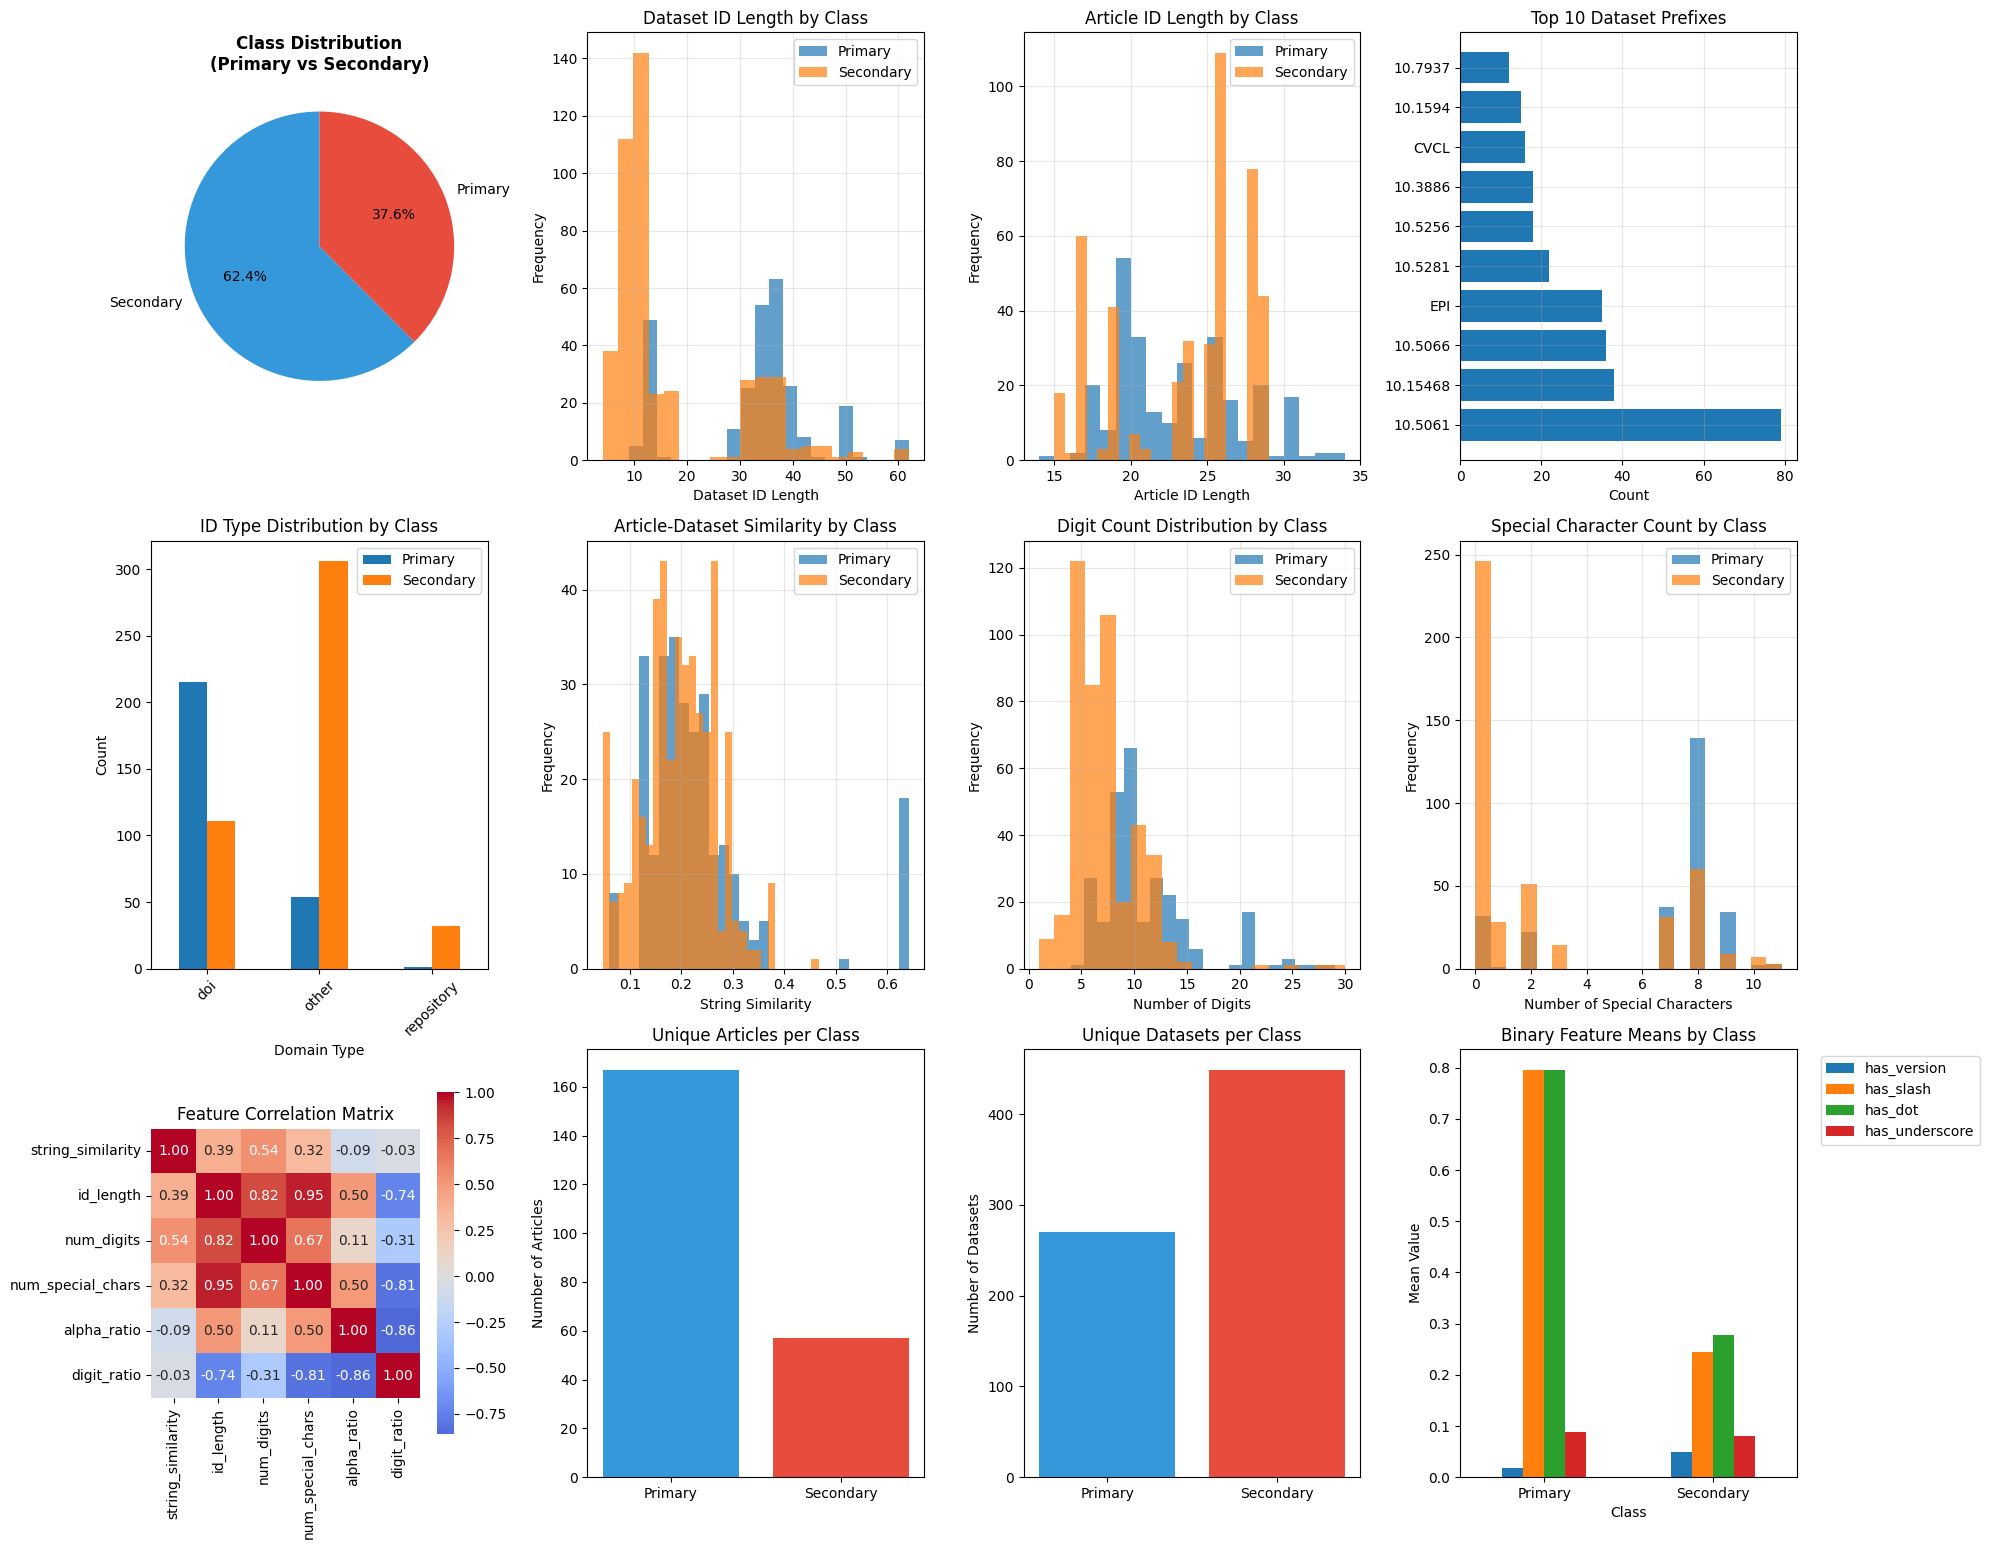

In [9]:
def create_data_exploration_plots(df_train):
    """Create comprehensive data exploration visualizations."""
    
    fig = plt.figure(figsize=(20, 16))
    
    plt.subplot(3, 4, 1)
    class_counts = df_train['type'].value_counts()
    colors = ['#3498db', '#e74c3c']
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Class Distribution\n(Primary vs Secondary)', fontweight='bold')
    
    plt.subplot(3, 4, 2)
    for class_type in df_train['type'].unique():
        subset = df_train[df_train['type'] == class_type]
        lengths = subset['dataset_id'].str.len()
        plt.hist(lengths, alpha=0.7, label=class_type, bins=20)
    plt.xlabel('Dataset ID Length')
    plt.ylabel('Frequency')
    plt.title('Dataset ID Length by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 3)
    for class_type in df_train['type'].unique():
        subset = df_train[df_train['type'] == class_type]
        lengths = subset['article_id'].str.len()
        plt.hist(lengths, alpha=0.7, label=class_type, bins=20)
    plt.xlabel('Article ID Length')
    plt.ylabel('Frequency')
    plt.title('Article ID Length by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 4)
    fx_temp = AdvancedFeatureExtractor()
    prefixes = df_train['dataset_id'].apply(fx_temp.extract_prefix)
    top_prefixes = prefixes.value_counts().head(10)
    plt.barh(range(len(top_prefixes)), top_prefixes.values)
    plt.yticks(range(len(top_prefixes)), top_prefixes.index)
    plt.xlabel('Count')
    plt.title('Top 10 Dataset Prefixes')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 5)
    df_temp = fx_temp.extract_all(df_train)
    cross_tab = pd.crosstab(df_temp['domain_type'], df_temp['type'])
    cross_tab.plot(kind='bar', ax=plt.gca())
    plt.title('ID Type Distribution by Class')
    plt.xlabel('Domain Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.subplot(3, 4, 6)
    similarities = df_temp.groupby('type')['string_similarity'].apply(list)
    for class_type, sims in similarities.items():
        plt.hist(sims, alpha=0.7, label=class_type, bins=30)
    plt.xlabel('String Similarity')
    plt.ylabel('Frequency')
    plt.title('Article-Dataset Similarity by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 7)
    digit_counts = df_temp.groupby('type')['num_digits'].apply(list)
    for class_type, digits in digit_counts.items():
        plt.hist(digits, alpha=0.7, label=class_type, bins=20)
    plt.xlabel('Number of Digits')
    plt.ylabel('Frequency')
    plt.title('Digit Count Distribution by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 8)
    special_counts = df_temp.groupby('type')['num_special_chars'].apply(list)
    for class_type, specials in special_counts.items():
        plt.hist(specials, alpha=0.7, label=class_type, bins=20)
    plt.xlabel('Number of Special Characters')
    plt.ylabel('Frequency')
    plt.title('Special Character Count by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 9)
    numerical_cols = ['string_similarity', 'id_length', 'num_digits', 
                      'num_special_chars', 'alpha_ratio', 'digit_ratio']
    corr_data = df_temp[numerical_cols].corr()
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix')
    
    plt.subplot(3, 4, 10)
    articles_per_class = df_train.groupby('type')['article_id'].nunique()
    plt.bar(articles_per_class.index, articles_per_class.values, color=colors)
    plt.title('Unique Articles per Class')
    plt.ylabel('Number of Articles')
    
    plt.subplot(3, 4, 11)
    datasets_per_class = df_train.groupby('type')['dataset_id'].nunique()
    plt.bar(datasets_per_class.index, datasets_per_class.values, color=colors)
    plt.title('Unique Datasets per Class')
    plt.ylabel('Number of Datasets')
    
    plt.subplot(3, 4, 12)
    feature_means = df_temp.groupby('type')[['has_version', 'has_slash', 'has_dot', 
                                            'has_underscore']].mean()
    feature_means.plot(kind='bar', ax=plt.gca())
    plt.title('Binary Feature Means by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return df_temp

print(" Creating comprehensive data exploration...")
df_train_features = create_data_exploration_plots(df_train)

Feature Engineering

In [10]:
fx = AdvancedFeatureExtractor()
print("Features (train)…")
df_tr_fx = fx.extract_all(df_train)

print("Features (test)…")
df_te_fx = fx.extract_all(df_test if not df_test.empty else pd.DataFrame(columns=['article_id','dataset_id']))

feature_cols = [
    'string_similarity','id_length','num_digits','num_special_chars','has_version',
    'is_doi','is_repository','is_other', 'has_slash', 'has_dot', 'has_underscore',
    'alpha_ratio', 'digit_ratio', 'uppercase_ratio',
    'article_prefix_encoded','dataset_prefix_encoded','domain_type_encoded'
]
feature_cols = [c for c in feature_cols if c in df_tr_fx.columns and c in df_te_fx.columns]  

X = df_tr_fx[feature_cols].astype(float)
y = df_tr_fx['type'].astype(str)
X_test = df_te_fx[feature_cols].astype(float)

print("Feature shapes")
print("   X:", X.shape, " y:", y.shape, " X_test:", X_test.shape)

Features (train)…
Features (test)…
Feature shapes
   X: (719, 17)  y: (719,)  X_test: (2155, 17)


Split + Scale with Advanced Analysis

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test) if len(X_test) else np.empty((0, X_train_s.shape[1]))

print("Split:")
print("   Train:", X_train_s.shape, " Val:", X_val_s.shape, " Test:", X_test_s.shape)

Split:
   Train: (575, 17)  Val: (144, 17)  Test: (2155, 17)


Enhanced Model Suite

In [12]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        random_state=42, class_weight='balanced_subsample', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
    ),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
               random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(
        C=2.0, max_iter=2000, random_state=42, class_weight='balanced', n_jobs=None
    ),
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski')
}
print(" Enhanced model suite ready")

 Enhanced model suite ready


Comprehensive Model Training & Evaluation

In [13]:
def comprehensive_model_evaluation(models, X_train_s, y_train, X_val_s, y_val):
    """Enhanced model evaluation with multiple metrics."""
    
    print(" Comprehensive model training & evaluation…")
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    metrics_data = []
    
    for name, model in models.items():
        print(f"\n {name}")
        model.fit(X_train_s, y_train)
        
        # Predictions
        y_pred = model.predict(X_val_s)
        y_proba = model.predict_proba(X_val_s) if hasattr(model, 'predict_proba') else None
        
        # Multiple metrics
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_weighted = f1_score(y_val, y_pred, average='weighted')
        accuracy = accuracy_score(y_val, y_pred)
        precision_macro = precision_score(y_val, y_pred, average='macro')
        recall_macro = recall_score(y_val, y_pred, average='macro')
        
        # ROC AUC for binary classification
        if y_proba is not None and len(np.unique(y_val)) == 2:
            roc_auc = roc_auc_score(y_val, y_proba[:, 1])
        else:
            roc_auc = np.nan
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_s, y_train, cv=cv, scoring='f1_macro')
        
        results[name] = {
            'model': model,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'roc_auc': roc_auc,
            'cv_mean': float(cv_scores.mean()),
            'cv_std': float(cv_scores.std()),
            'y_pred': y_pred,
            'y_proba': y_proba,
            'report': classification_report(y_val, y_pred, digits=4)
        }
        
        # Store for comparison visualization
        metrics_data.append({
            'Model': name,
            'F1_Macro': f1_macro,
            'F1_Weighted': f1_weighted,
            'Accuracy': accuracy,
            'Precision_Macro': precision_macro,
            'Recall_Macro': recall_macro,
            'ROC_AUC': roc_auc,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std()
        })
        
        print(f"   F1(macro): {f1_macro:.4f} | Accuracy: {accuracy:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return results, pd.DataFrame(metrics_data)

results, metrics_df = comprehensive_model_evaluation(models, X_train_s, y_train, X_val_s, y_val)

best_name = max(results, key=lambda k: results[k]['f1_macro'])
best_model = results[best_name]['model']
print(f"\n Best: {best_name} | F1(macro): {results[best_name]['f1_macro']:.4f}")

 Comprehensive model training & evaluation…

 Random Forest
   F1(macro): 0.9340 | Accuracy: 0.9375 | CV: 0.9236 ± 0.0211

 Gradient Boosting
   F1(macro): 0.9407 | Accuracy: 0.9444 | CV: 0.9137 ± 0.0224

 SVM
   F1(macro): 0.8453 | Accuracy: 0.8472 | CV: 0.8359 ± 0.0375

 Logistic Regression
   F1(macro): 0.8239 | Accuracy: 0.8264 | CV: 0.8094 ± 0.0375

 KNN
   F1(macro): 0.9188 | Accuracy: 0.9236 | CV: 0.8858 ± 0.0305

 Best: Gradient Boosting | F1(macro): 0.9407


Advanced Visualization Suite

 Creating advanced visualization suite...


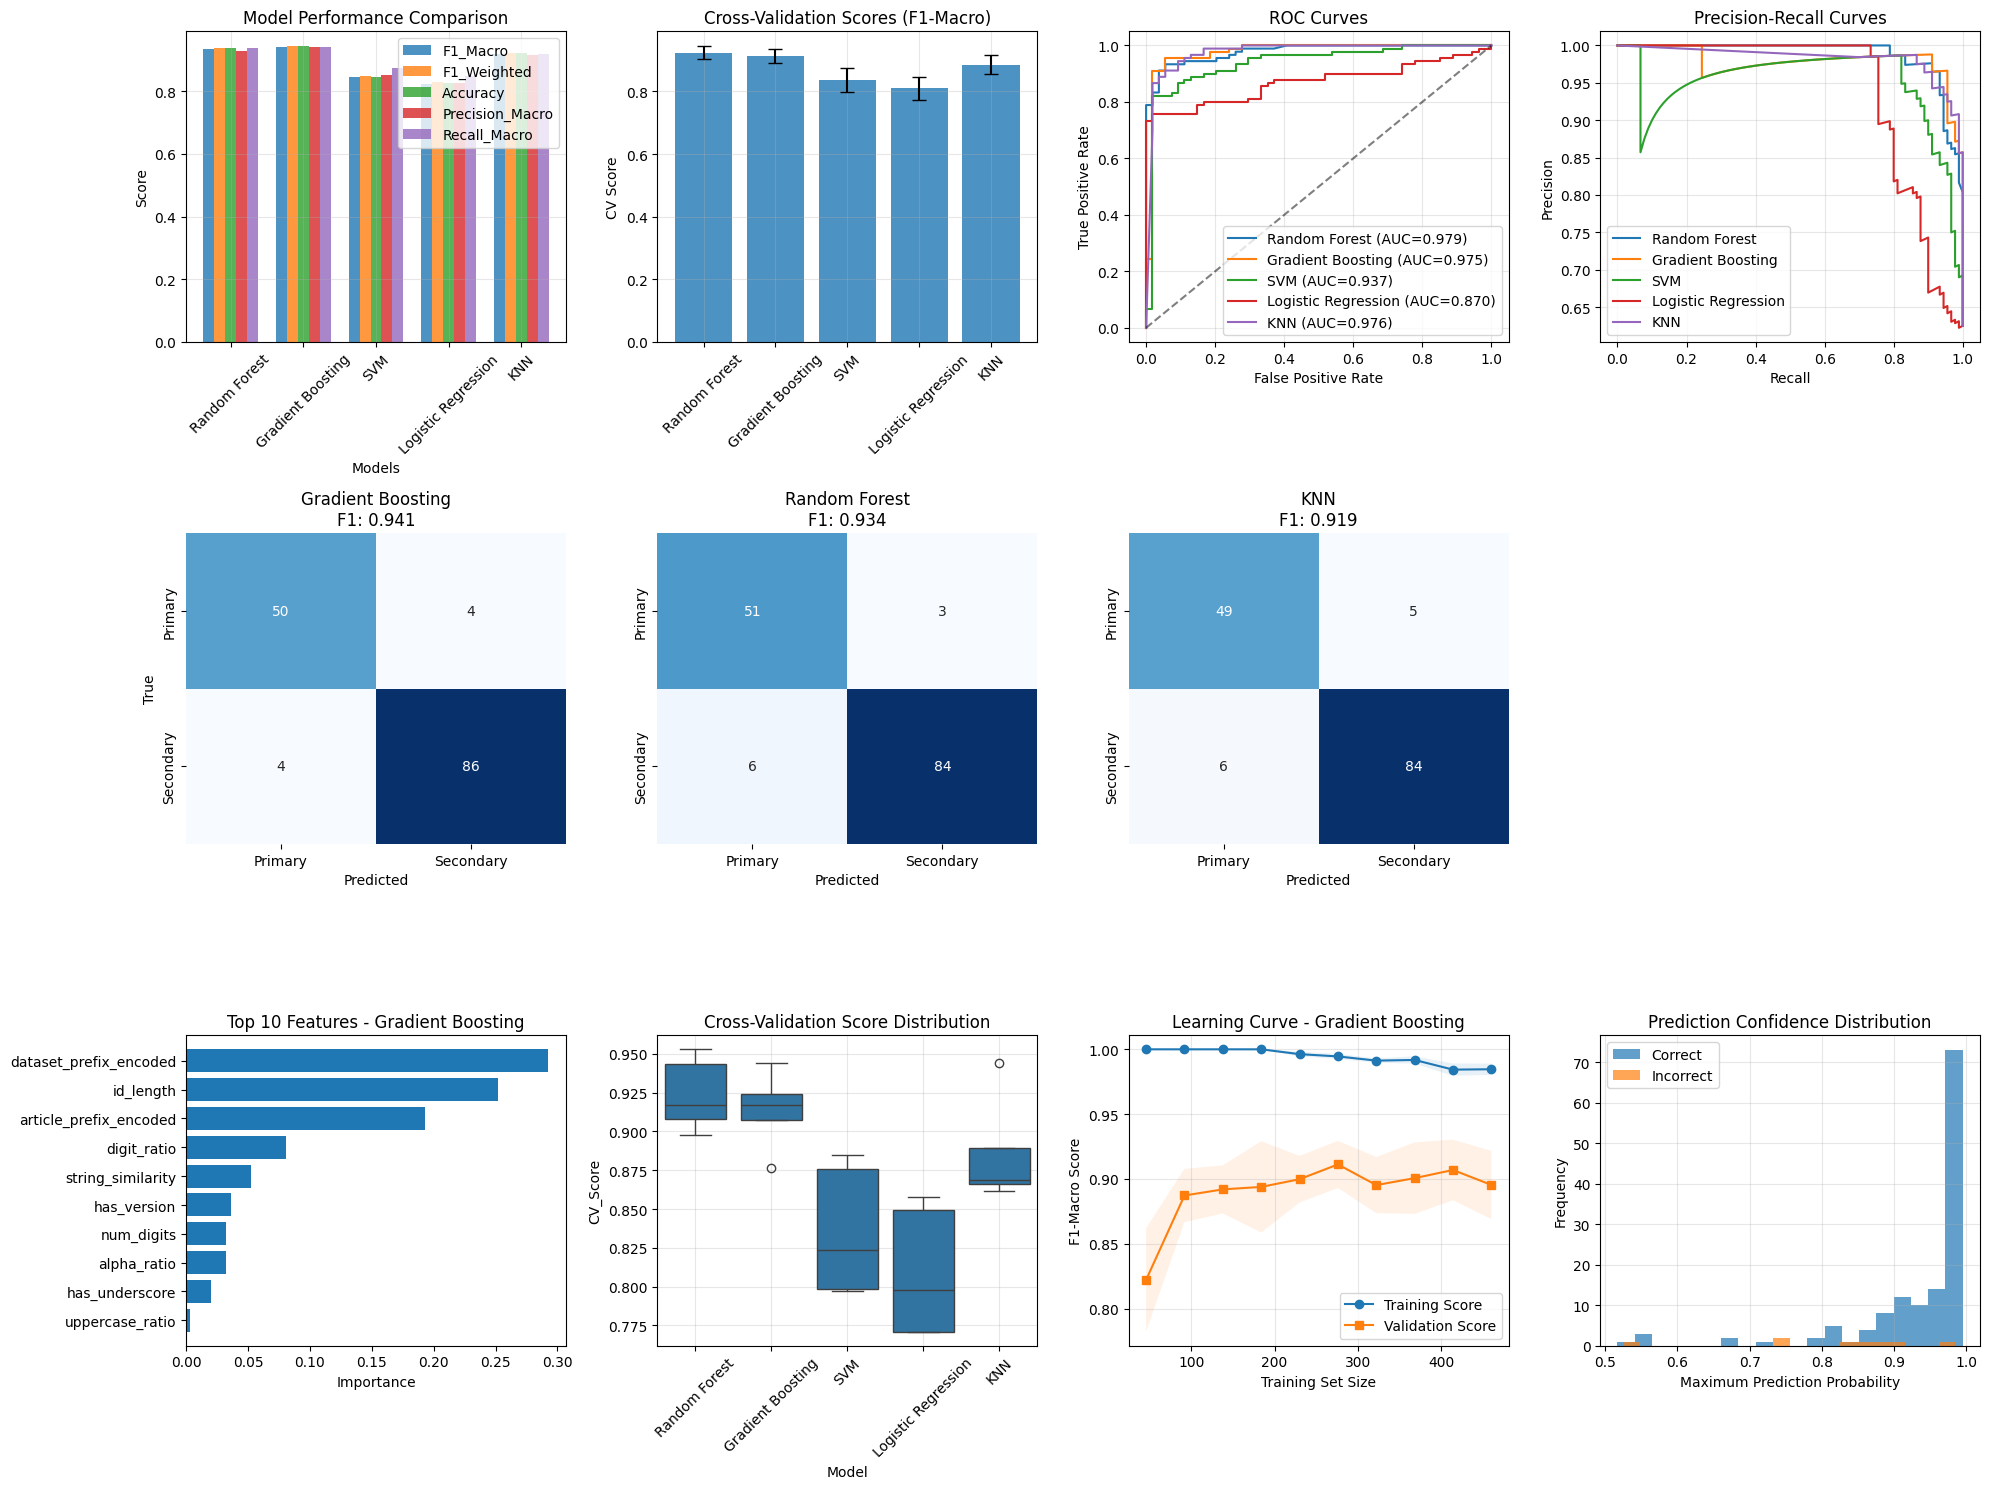

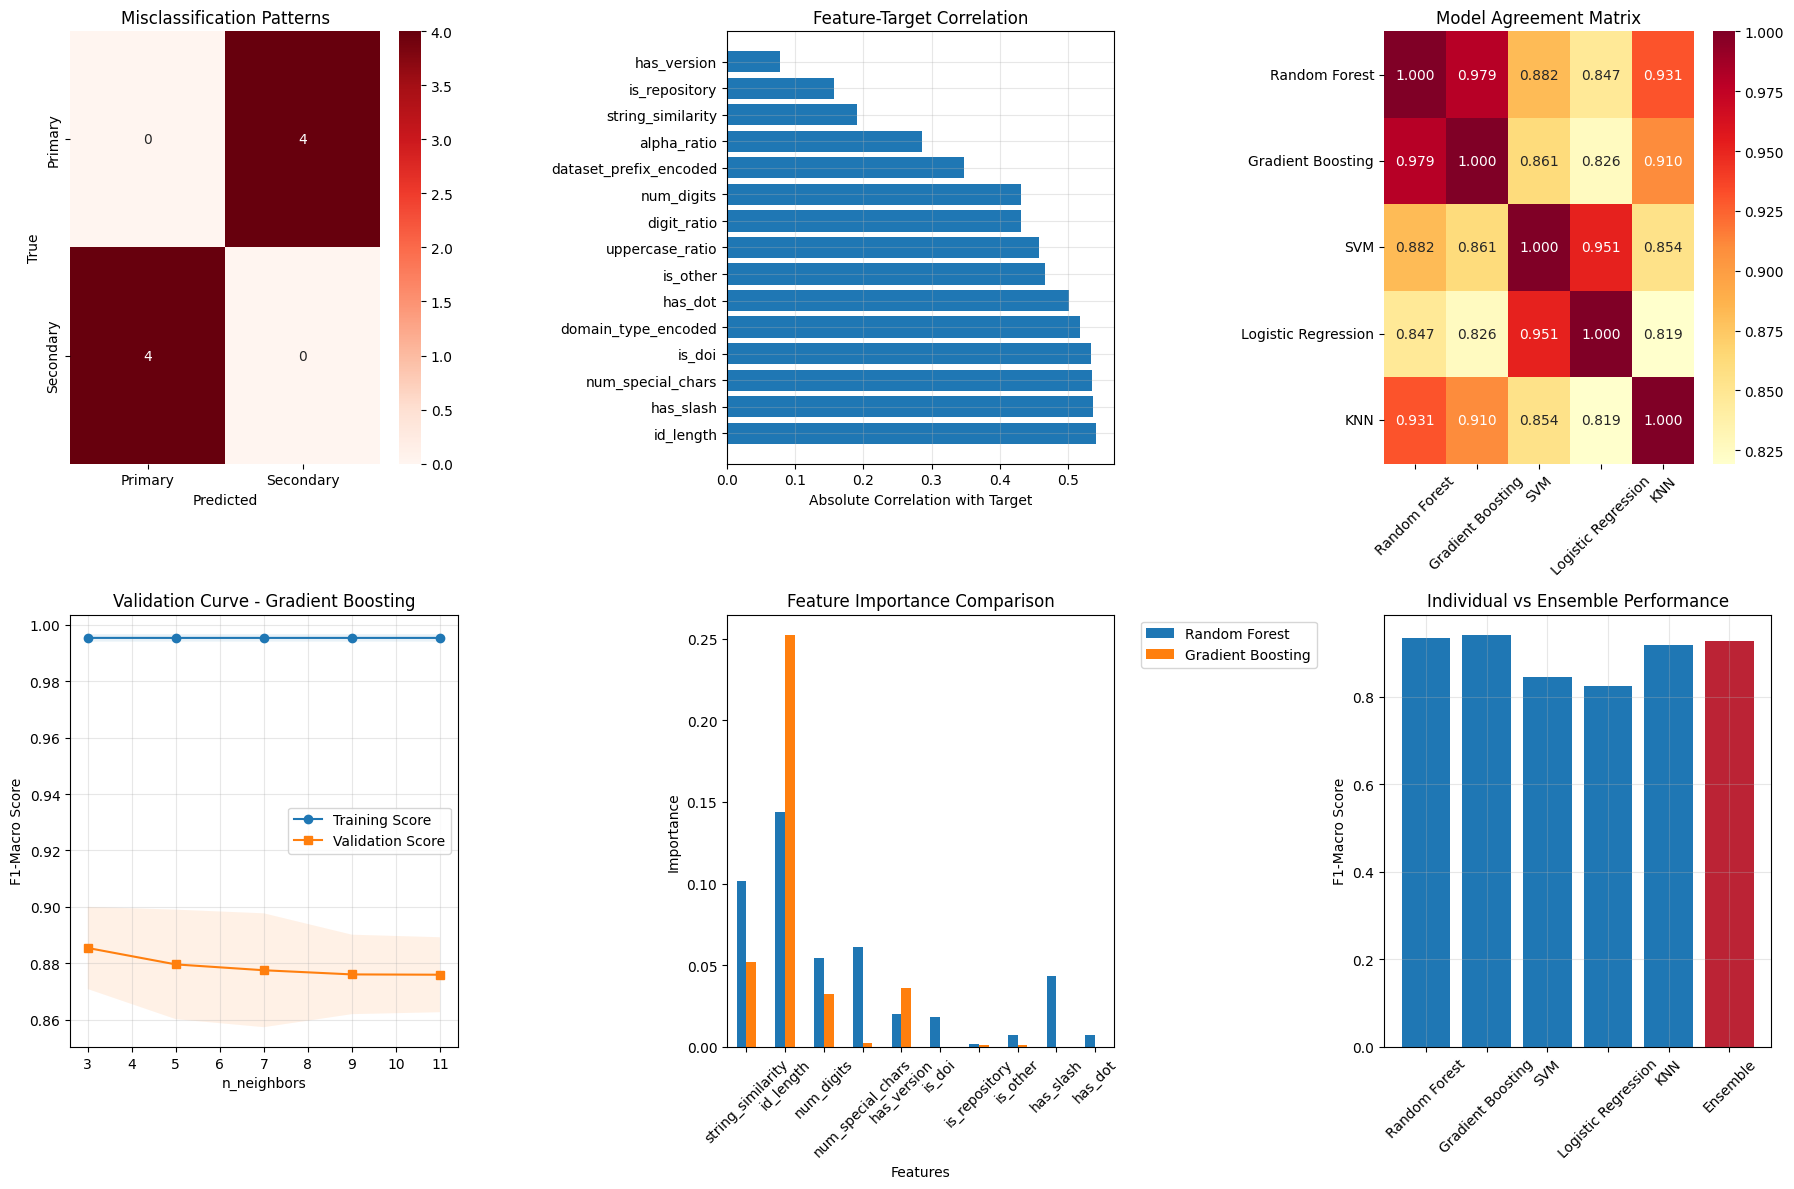

In [14]:
def create_advanced_visualizations(results, metrics_df, y_val, feature_cols):
    """Create comprehensive visualization suite."""
    
    # 1. Model Comparison Dashboard
    fig = plt.figure(figsize=(20, 15))
    
    # Metrics comparison
    plt.subplot(3, 4, 1)
    metrics_to_plot = ['F1_Macro', 'F1_Weighted', 'Accuracy', 'Precision_Macro', 'Recall_Macro']
    x = np.arange(len(metrics_df))
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x + i * width, metrics_df[metric], width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width * 2, metrics_df['Model'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Cross-validation scores with error bars
    plt.subplot(3, 4, 2)
    plt.bar(metrics_df['Model'], metrics_df['CV_Mean'], 
            yerr=metrics_df['CV_Std'], capsize=5, alpha=0.8)
    plt.title('Cross-Validation Scores (F1-Macro)')
    plt.ylabel('CV Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # ROC Curves (if available)
    plt.subplot(3, 4, 3)
    labels_sorted = sorted(y_val.unique())
    if len(labels_sorted) == 2:  # Binary classification
        for name, result in results.items():
            if result['y_proba'] is not None:
                fpr, tpr, _ = roc_curve(y_val, result['y_proba'][:, 1], 
                                      pos_label=labels_sorted[1])
                plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    plt.subplot(3, 4, 4)
    if len(labels_sorted) == 2:
        for name, result in results.items():
            if result['y_proba'] is not None:
                precision, recall, _ = precision_recall_curve(y_val, result['y_proba'][:, 1],
                                                            pos_label=labels_sorted[1])
                plt.plot(recall, precision, label=name)
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Confusion matrices for top models
    top_models = metrics_df.nlargest(3, 'F1_Macro')['Model'].tolist()
    
    for i, model_name in enumerate(top_models[:3]):
        plt.subplot(3, 4, 5 + i)
        cm = confusion_matrix(y_val, results[model_name]['y_pred'], labels=labels_sorted)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels_sorted, yticklabels=labels_sorted,
                   cbar=False)
        plt.title(f'{model_name}\nF1: {results[model_name]["f1_macro"]:.3f}')
        plt.ylabel('True' if i == 0 else '')
        plt.xlabel('Predicted')
    
    # Feature importance (for tree-based models)
    plt.subplot(3, 4, 9)
    best_result = results[best_name]
    if hasattr(best_result['model'], 'feature_importances_'):
        imp_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_result['model'].feature_importances_
        }).sort_values('importance', ascending=True)
        
        plt.barh(range(len(imp_df.tail(10))), imp_df.tail(10)['importance'])
        plt.yticks(range(len(imp_df.tail(10))), imp_df.tail(10)['feature'])
        plt.title(f'Top 10 Features - {best_name}')
        plt.xlabel('Importance')
    
    # Model stability (CV scores distribution)
    plt.subplot(3, 4, 10)
    cv_data = []
    for name in results:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(results[name]['model'], X_train_s, y_train, 
                               cv=cv, scoring='f1_macro')
        cv_data.extend([(name, score) for score in scores])
    
    cv_df = pd.DataFrame(cv_data, columns=['Model', 'CV_Score'])
    sns.boxplot(data=cv_df, x='Model', y='CV_Score')
    plt.title('Cross-Validation Score Distribution')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Learning curves for best model
    plt.subplot(3, 4, 11)
    train_sizes, train_scores, val_scores = learning_curve(
        best_result['model'], X_train_s, y_train, cv=5, 
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Validation Score', marker='s')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('F1-Macro Score')
    plt.title(f'Learning Curve - {best_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Prediction confidence distribution
    plt.subplot(3, 4, 12)
    if best_result['y_proba'] is not None:
        max_proba = np.max(best_result['y_proba'], axis=1)
        correct_mask = (best_result['y_pred'] == y_val)
        
        plt.hist(max_proba[correct_mask], alpha=0.7, label='Correct', bins=20)
        plt.hist(max_proba[~correct_mask], alpha=0.7, label='Incorrect', bins=20)
        plt.xlabel('Maximum Prediction Probability')
        plt.ylabel('Frequency')
        plt.title('Prediction Confidence Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional detailed analysis plots
    create_detailed_analysis_plots(results, y_val, labels_sorted)

def create_detailed_analysis_plots(results, y_val, labels_sorted):
    """Create additional detailed analysis plots."""
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Error Analysis - Misclassification patterns
    plt.subplot(2, 3, 1)
    best_result = results[best_name]
    misclassified_idx = y_val != best_result['y_pred']
    
    if sum(misclassified_idx) > 0:
        error_df = pd.DataFrame({
            'True': y_val[misclassified_idx],
            'Predicted': best_result['y_pred'][misclassified_idx]
        })
        error_counts = error_df.groupby(['True', 'Predicted']).size().unstack(fill_value=0)
        sns.heatmap(error_counts, annot=True, fmt='d', cmap='Reds')
        plt.title('Misclassification Patterns')
    
    # 2. Feature correlation with target
    plt.subplot(2, 3, 2)
    feature_target_corr = []
    for col in feature_cols:
        if col in df_tr_fx.columns:
            # Convert target to numeric for correlation
            y_numeric = (df_tr_fx['type'] == 'Primary').astype(int)
            corr = df_tr_fx[col].corr(y_numeric)
            feature_target_corr.append((col, abs(corr)))
    
    feature_target_corr.sort(key=lambda x: x[1], reverse=True)
    features, correlations = zip(*feature_target_corr[:15])
    
    plt.barh(range(len(features)), correlations)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Absolute Correlation with Target')
    plt.title('Feature-Target Correlation')
    plt.grid(True, alpha=0.3)
    
    # 3. Model agreement analysis
    plt.subplot(2, 3, 3)
    predictions_df = pd.DataFrame({name: result['y_pred'] for name, result in results.items()})
    
    # Calculate pairwise agreement
    agreement_matrix = np.zeros((len(results), len(results)))
    model_names = list(results.keys())
    
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names):
            agreement = (predictions_df[model1] == predictions_df[model2]).mean()
            agreement_matrix[i, j] = agreement
    
    sns.heatmap(agreement_matrix, annot=True, fmt='.3f', 
                xticklabels=model_names, yticklabels=model_names,
                cmap='YlOrRd')
    plt.title('Model Agreement Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 4. Validation curve for best model hyperparameter
    plt.subplot(2, 3, 4)
    if best_name == 'Random Forest':
        param_name = 'n_estimators'
        param_range = [50, 100, 200, 300, 500]
        model_for_validation = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
    elif best_name == 'SVM':
        param_name = 'C'
        param_range = [0.1, 1, 10, 100]
        model_for_validation = SVC(random_state=42, class_weight='balanced')
    elif best_name == 'Logistic Regression':
        param_name = 'C'
        param_range = [0.1, 1, 2, 5, 10]
        model_for_validation = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000)
    else:
        param_name = 'n_neighbors'
        param_range = [3, 5, 7, 9, 11]
        model_for_validation = KNeighborsClassifier(weights='distance')
    
    train_scores, val_scores = validation_curve(
        model_for_validation, X_train_s, y_train, param_name=param_name,
        param_range=param_range, cv=3, scoring='f1_macro'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.plot(param_range, train_mean, label='Training Score', marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(param_range, val_mean, label='Validation Score', marker='s')
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1)
    
    plt.xlabel(param_name)
    plt.ylabel('F1-Macro Score')
    plt.title(f'Validation Curve - {best_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Feature importance comparison (for applicable models)
    plt.subplot(2, 3, 5)
    importances = {}
    for name, result in results.items():
        if hasattr(result['model'], 'feature_importances_'):
            importances[name] = result['model'].feature_importances_
    
    if importances:
        imp_df = pd.DataFrame(importances, index=feature_cols)
        imp_df.head(10).plot(kind='bar', ax=plt.gca())
        plt.title('Feature Importance Comparison')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Ensemble prediction analysis
    plt.subplot(2, 3, 6)
    if len(results) >= 3:
        # Simple voting ensemble
        ensemble_pred = []
        for i in range(len(y_val)):
            votes = [result['y_pred'][i] for result in results.values()]
            ensemble_pred.append(max(set(votes), key=votes.count))
        
        ensemble_f1 = f1_score(y_val, ensemble_pred, average='macro')
        
        # Compare ensemble with individual models
        f1_scores = [result['f1_macro'] for result in results.values()]
        f1_scores.append(ensemble_f1)
        model_names_with_ensemble = list(results.keys()) + ['Ensemble']
        
        plt.bar(model_names_with_ensemble, f1_scores)
        plt.title('Individual vs Ensemble Performance')
        plt.ylabel('F1-Macro Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Highlight ensemble
        plt.bar(['Ensemble'], [ensemble_f1], color='red', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Create comprehensive visualizations
print(" Creating advanced visualization suite...")
create_advanced_visualizations(results, metrics_df, y_val, feature_cols)

Statistical Analysis and Insights

In [15]:
def perform_statistical_analysis(df_tr_fx, results, y_val):
    """Perform statistical analysis and generate insights."""
    
    print(" STATISTICAL ANALYSIS & INSIGHTS")
    print("=" * 60)
    
    # 1. Dataset characteristics analysis
    print("\n Dataset Characteristics:")
    print(f"   • Total training samples: {len(df_tr_fx)}")
    print(f"   • Class distribution: {dict(df_tr_fx['type'].value_counts())}")
    print(f"   • Unique articles: {df_tr_fx['article_id'].nunique()}")
    print(f"   • Unique datasets: {df_tr_fx['dataset_id'].nunique()}")
    
    # Calculate class imbalance ratio
    class_counts = df_tr_fx['type'].value_counts()
    imbalance_ratio = max(class_counts) / min(class_counts)
    print(f"   • Class imbalance ratio: {imbalance_ratio:.2f}")
    
    # 2. Feature statistics by class
    print("\n Feature Statistics by Class:")
    feature_stats = df_tr_fx.groupby('type')[['string_similarity', 'id_length', 
                                             'num_digits', 'alpha_ratio']].agg(['mean', 'std'])
    print(feature_stats.round(3))
    
    # 3. Model performance analysis
    print("\n Model Performance Analysis:")
    best_f1 = max(result['f1_macro'] for result in results.values())
    worst_f1 = min(result['f1_macro'] for result in results.values())
    performance_range = best_f1 - worst_f1
    
    print(f"   • Best F1-macro: {best_f1:.4f} ({best_name})")
    print(f"   • Worst F1-macro: {worst_f1:.4f}")
    print(f"   • Performance range: {performance_range:.4f}")
    
    # 4. Cross-validation stability analysis
    print("\n🔄 Cross-Validation Stability:")
    for name, result in results.items():
        cv_stability = result['cv_std'] / result['cv_mean'] if result['cv_mean'] > 0 else 0
        print(f"   • {name}: CV={result['cv_mean']:.4f}±{result['cv_std']:.4f} (stability: {cv_stability:.3f})")
    
    # 5. Error analysis
    print("\n Error Analysis:")
    best_result = results[best_name]
    total_errors = sum(y_val != best_result['y_pred'])
    error_rate = total_errors / len(y_val)
    print(f"   • Total misclassifications: {total_errors}")
    print(f"   • Error rate: {error_rate:.4f}")
    
    # Per-class error analysis
    for class_label in sorted(y_val.unique()):
        class_mask = y_val == class_label
        class_errors = sum((y_val[class_mask] != best_result['y_pred'][class_mask]))
        class_total = sum(class_mask)
        class_error_rate = class_errors / class_total if class_total > 0 else 0
        print(f"   • {class_label} error rate: {class_error_rate:.4f} ({class_errors}/{class_total})")
    
    # 6. Feature importance insights
    print("\n Feature Importance Insights:")
    if hasattr(best_result['model'], 'feature_importances_'):
        feature_imp = list(zip(feature_cols, best_result['model'].feature_importances_))
        feature_imp.sort(key=lambda x: x[1], reverse=True)
        
        print("   Top 5 most important features:")
        for feat, imp in feature_imp[:5]:
            print(f"     • {feat}: {imp:.4f}")
        
        # Feature categories analysis
        domain_features = [f for f, _ in feature_imp if 'domain' in f or 'is_' in f]
        text_features = [f for f, _ in feature_imp if 'similarity' in f or 'length' in f]
        structural_features = [f for f, _ in feature_imp if 'num_' in f or 'has_' in f or 'ratio' in f]
        
        print(f"\n   Feature category importance:")
        for category, features in [('Domain', domain_features), ('Text', text_features), ('Structural', structural_features)]:
            if features:
                avg_importance = np.mean([imp for feat, imp in feature_imp if feat in features])
                print(f"     • {category} features avg importance: {avg_importance:.4f}")

# Perform comprehensive statistical analysis
perform_statistical_analysis(df_tr_fx, results, y_val)

 STATISTICAL ANALYSIS & INSIGHTS

 Dataset Characteristics:
   • Total training samples: 719
   • Class distribution: {'Secondary': np.int64(449), 'Primary': np.int64(270)}
   • Unique articles: 214
   • Unique datasets: 719
   • Class imbalance ratio: 1.66

 Feature Statistics by Class:
          string_similarity        id_length         num_digits         \
                       mean    std      mean     std       mean    std   
type                                                                     
Primary               0.234  0.127    32.959  11.950     10.900  4.444   
Secondary             0.195  0.073    16.840  12.254      7.229  3.226   

          alpha_ratio         
                 mean    std  
type                          
Primary         0.458  0.075  
Secondary       0.389  0.131  

 Model Performance Analysis:
   • Best F1-macro: 0.9407 (Gradient Boosting)
   • Worst F1-macro: 0.8239
   • Performance range: 0.1168

🔄 Cross-Validation Stability:
   • Random Forest

Interactive Visualizations (if Plotly available)

In [16]:
if PLOTLY_AVAILABLE:
    def create_interactive_plots(results, metrics_df, df_tr_fx):
        """Create interactive visualizations using Plotly."""
        
        print(" Creating interactive visualizations...")
        
        # 1. Interactive model comparison
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Model Performance Metrics', 'Cross-Validation Scores',
                          'Feature Importance (Best Model)', 'Prediction Confidence'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # Model metrics comparison
        metrics_to_show = ['F1_Macro', 'Accuracy', 'Precision_Macro', 'Recall_Macro']
        for metric in metrics_to_show:
            fig.add_trace(
                go.Bar(name=metric, x=metrics_df['Model'], y=metrics_df[metric],
                      text=metrics_df[metric].round(3), textposition='auto'),
                row=1, col=1
            )
        
        # CV scores with error bars
        fig.add_trace(
            go.Bar(name='CV Score', x=metrics_df['Model'], y=metrics_df['CV_Mean'],
                  error_y=dict(type='data', array=metrics_df['CV_Std']),
                  text=metrics_df['CV_Mean'].round(3), textposition='auto'),
            row=1, col=2
        )
        
        # Feature importance (if available)
        best_result = results[best_name]
        if hasattr(best_result['model'], 'feature_importances_'):
            feature_imp_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': best_result['model'].feature_importances_
            }).sort_values('importance', ascending=True).tail(10)
            
            fig.add_trace(
                go.Bar(name='Importance', x=feature_imp_df['importance'], 
                      y=feature_imp_df['feature'], orientation='h',
                      text=feature_imp_df['importance'].round(3), textposition='auto'),
                row=2, col=1
            )
        
        # Prediction confidence distribution
        if best_result['y_proba'] is not None:
            max_proba = np.max(best_result['y_proba'], axis=1)
            
            fig.add_trace(
                go.Histogram(x=max_proba, name='Confidence Distribution', nbinsx=20),
                row=2, col=2
            )
        
        fig.update_layout(height=800, showlegend=True, 
                         title_text="Interactive Model Analysis Dashboard")
        fig.show()
        
        # 2. Interactive feature exploration
        fig_features = px.scatter_matrix(
            df_tr_fx[['string_similarity', 'id_length', 'num_digits', 'alpha_ratio', 'type']],
            dimensions=['string_similarity', 'id_length', 'num_digits', 'alpha_ratio'],
            color='type',
            title="Interactive Feature Correlation Matrix"
        )
        fig_features.show()
        
        # 3. Interactive ROC curves
        if len(sorted(y_val.unique())) == 2:
            fig_roc = go.Figure()
            
            for name, result in results.items():
                if result['y_proba'] is not None:
                    fpr, tpr, _ = roc_curve(y_val, result['y_proba'][:, 1])
                    fig_roc.add_trace(go.Scatter(
                        x=fpr, y=tpr, mode='lines',
                        name=f"{name} (AUC={result['roc_auc']:.3f})",
                        hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>'
                    ))
            
            fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', 
                                        line=dict(dash='dash', color='gray'),
                                        name='Random Classifier'))
            
            fig_roc.update_layout(
                title='Interactive ROC Curves',
                xaxis_title='False Positive Rate',
                yaxis_title='True Positive Rate'
            )
            fig_roc.show()
    
    # Create interactive plots
    create_interactive_plots(results, metrics_df, df_tr_fx)


Word Cloud Analysis (if available)

In [17]:
if WORDCLOUD_AVAILABLE:
    def create_wordcloud_analysis(df_tr_fx):
        """Create word cloud analysis for dataset IDs."""
        
        print("☁️ Creating word cloud analysis...")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        for i, class_type in enumerate(['Primary', 'Secondary']):
            class_data = df_tr_fx[df_tr_fx['type'] == class_type]
            
            # Combine all dataset IDs for this class
            text = ' '.join(class_data['dataset_id'].astype(str))
            
            # Create word cloud
            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=100,
                colormap='viridis' if class_type == 'Primary' else 'plasma'
            ).generate(text)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{class_type} Dataset IDs Word Cloud')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Create word cloud analysis
    create_wordcloud_analysis(df_tr_fx)


Advanced Feature Analysis

 Model Interpretability Analysis

 Feature Importance Ranking:
    1. dataset_prefix_encoded   : 0.2922
    2. id_length                : 0.2521
    3. article_prefix_encoded   : 0.1929
    4. digit_ratio              : 0.0808
    5. string_similarity        : 0.0521
    6. has_version              : 0.0362
    7. num_digits               : 0.0324
    8. alpha_ratio              : 0.0319
    9. has_underscore           : 0.0198
   10. uppercase_ratio          : 0.0032

   Features explaining 90% of importance: 5/17

 Prediction Confidence Analysis:
   • High confidence (>0.8):    132 samples (91.7%)
   • Medium confidence (0.6-0.8):    7 samples (4.9%)
   • Low confidence (<0.6):       5 samples (3.5%)
   • High confidence accuracy: 0.962
   • Medium confidence accuracy: 0.714
   • Low confidence accuracy: 0.800

 Creating decision boundary visualization...


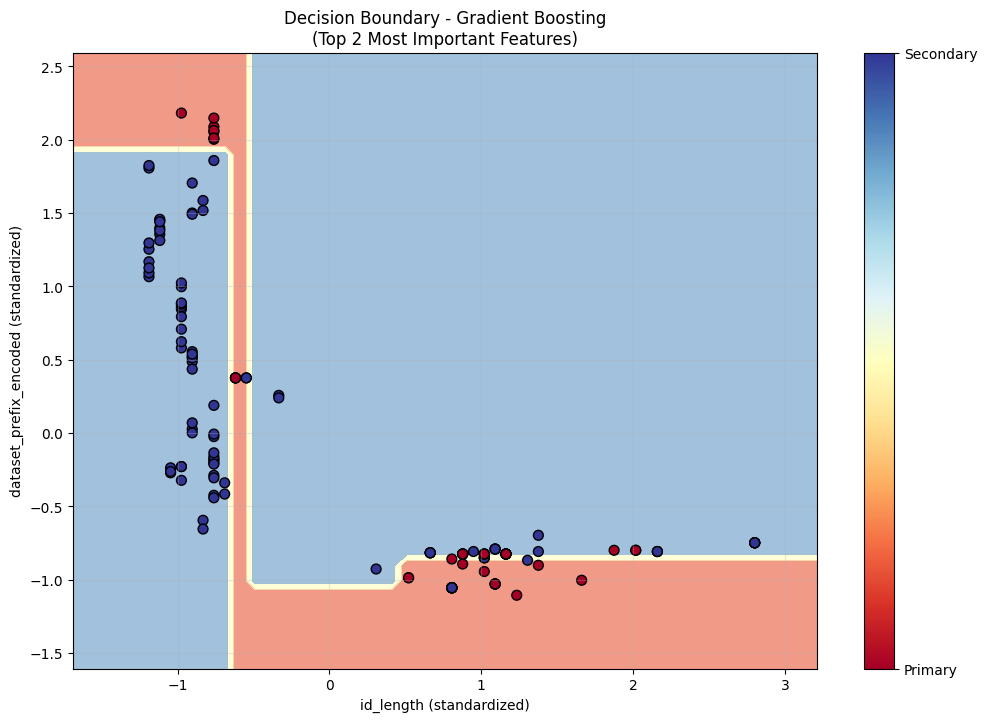

In [18]:
def model_interpretability_analysis(best_model, X_val_s, y_val, feature_cols):
    """Analyze model interpretability and decision boundaries."""
    
    print(" Model Interpretability Analysis")
    print("=" * 50)
    
    # 1. Feature importance ranking
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\n Feature Importance Ranking:")
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:25s}: {row['importance']:.4f}")
        
        # Calculate cumulative importance
        feature_importance['cumulative'] = feature_importance['importance'].cumsum()
        features_90_percent = len(feature_importance[feature_importance['cumulative'] <= 0.9])
        print(f"\n   Features explaining 90% of importance: {features_90_percent}/{len(feature_cols)}")
    
    # 2. Prediction confidence analysis
    if hasattr(best_model, 'predict_proba'):
        probabilities = best_model.predict_proba(X_val_s)
        max_probabilities = np.max(probabilities, axis=1)
        predictions = best_model.predict(X_val_s)
        
        # Analyze confidence levels
        high_confidence = max_probabilities > 0.8
        medium_confidence = (max_probabilities > 0.6) & (max_probabilities <= 0.8)
        low_confidence = max_probabilities <= 0.6
        
        print(f"\n Prediction Confidence Analysis:")
        print(f"   • High confidence (>0.8):   {sum(high_confidence):4d} samples ({sum(high_confidence)/len(y_val)*100:.1f}%)")
        print(f"   • Medium confidence (0.6-0.8): {sum(medium_confidence):4d} samples ({sum(medium_confidence)/len(y_val)*100:.1f}%)")
        print(f"   • Low confidence (<0.6):    {sum(low_confidence):4d} samples ({sum(low_confidence)/len(y_val)*100:.1f}%)")
        
        # Accuracy by confidence level
        for conf_name, conf_mask in [('High', high_confidence), ('Medium', medium_confidence), ('Low', low_confidence)]:
            if sum(conf_mask) > 0:
                conf_accuracy = accuracy_score(y_val[conf_mask], predictions[conf_mask])
                print(f"   • {conf_name} confidence accuracy: {conf_accuracy:.3f}")
    
    # 3. Decision boundary visualization (for 2D projection)
    print(f"\n Creating decision boundary visualization...")
    
    # Use top 2 most important features for 2D visualization
    if hasattr(best_model, 'feature_importances_') and len(feature_cols) >= 2:
        try:
            top_features_idx = np.argsort(best_model.feature_importances_)[-2:]
            X_2d = X_val_s[:, top_features_idx]
            
            # Convert string labels to numeric for visualization
            from sklearn.preprocessing import LabelEncoder
            label_encoder = LabelEncoder()
            y_val_numeric = label_encoder.fit_transform(y_val)
            
            # Create a mesh with reasonable resolution
            h = 0.1  # Increased step size for better performance
            x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
            y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                np.arange(y_min, y_max, h))
            
            # Create a temporary model with just 2 features
            from sklearn.base import clone
            temp_model = clone(best_model)
            temp_model.fit(X_2d, y_val)
            
            # Predict on mesh
            mesh_points = np.c_[xx.ravel(), yy.ravel()]
            Z_pred = temp_model.predict(mesh_points)
            Z_numeric = label_encoder.transform(Z_pred)
            Z = Z_numeric.reshape(xx.shape)
            
            # Plot
            plt.figure(figsize=(12, 8))
            
            # Create contour plot
            contour = plt.contourf(xx, yy, Z, alpha=0.6, cmap='RdYlBu', levels=len(np.unique(y_val_numeric)))
            
            # Plot data points
            scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_val_numeric, 
                                cmap='RdYlBu', edgecolors='black', s=50)
            
            # Add colorbar with proper labels
            cbar = plt.colorbar(scatter)
            cbar.set_ticks(range(len(label_encoder.classes_)))
            cbar.set_ticklabels(label_encoder.classes_)
            
            plt.xlabel(f'{feature_cols[top_features_idx[0]]} (standardized)')
            plt.ylabel(f'{feature_cols[top_features_idx[1]]} (standardized)')
            plt.title(f'Decision Boundary - {best_name}\n(Top 2 Most Important Features)')
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            print(f"    Could not create decision boundary plot: {e}")
            print("    Creating alternative feature importance plot instead...")
            
            # Alternative: Feature importance plot
            plt.figure(figsize=(10, 6))
            feature_imp_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=True).tail(10)
            
            plt.barh(range(len(feature_imp_df)), feature_imp_df['importance'])
            plt.yticks(range(len(feature_imp_df)), feature_imp_df['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 10 Feature Importance - {best_name}')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    else:
        print("   📊 Feature importances not available - skipping decision boundary plot")

# Perform model interpretability analysis
model_interpretability_analysis(best_model, X_val_s, y_val, feature_cols)

In [19]:
print(f"\n Predicting test with {best_name}…")
y_test = best_model.predict(X_test_s) if len(X_test_s) else np.array([], dtype=str)

# Enhanced submission with confidence scores
submission = (df_test[['row_id','article_id','dataset_id']].copy()
              if not df_test.empty else pd.DataFrame(columns=['row_id','article_id','dataset_id']))
submission['type'] = y_test

# Add confidence scores if available
if hasattr(best_model, 'predict_proba') and len(X_test_s) > 0:
    test_probabilities = best_model.predict_proba(X_test_s)
    submission['confidence'] = np.max(test_probabilities, axis=1)
    
    # Add individual class probabilities
    class_names = best_model.classes_
    for i, class_name in enumerate(class_names):
        submission[f'prob_{class_name}'] = test_probabilities[:, i]

print(" Enhanced submission shape:", submission.shape)
if len(submission):
    submission.to_csv('enhanced_submission.csv', index=False)
    print(" Saved enhanced_submission.csv with confidence scores")
    
    # Create submission summary
    print(f"\n Submission Summary:")
    if 'confidence' in submission.columns:
        print(f"   • Average confidence: {submission['confidence'].mean():.3f}")
        print(f"   • High confidence predictions (>0.8): {sum(submission['confidence'] > 0.8)}")
        print(f"   • Low confidence predictions (<0.6): {sum(submission['confidence'] < 0.6)}")
else:
    print(" No test candidates found; nothing to save.")


 Predicting test with Gradient Boosting…
 Enhanced submission shape: (2155, 7)
 Saved enhanced_submission.csv with confidence scores

 Submission Summary:
   • Average confidence: 0.957
   • High confidence predictions (>0.8): 2054
   • Low confidence predictions (<0.6): 4


Final Model Ensemble and Stacking

In [20]:
def create_ensemble_model(results, X_train_s, y_train, X_val_s, y_val):
    """Create an ensemble model using multiple approaches."""
    
    print(" Creating Advanced Ensemble Models")
    print("=" * 50)
    
    # 1. Simple Voting Ensemble
    predictions = np.array([result['y_pred'] for result in results.values()]).T
    
    # Majority voting
    ensemble_predictions = []
    for i in range(len(predictions)):
        votes = predictions[i]
        ensemble_predictions.append(max(set(votes), key=list(votes).count))
    
    ensemble_f1 = f1_score(y_val, ensemble_predictions, average='macro')
    ensemble_accuracy = accuracy_score(y_val, ensemble_predictions)
    
    print(f"\n Voting Ensemble Results:")
    print(f"   • F1-Macro: {ensemble_f1:.4f}")
    print(f"   • Accuracy: {ensemble_accuracy:.4f}")
    
    # 2. Weighted Ensemble (based on individual performance)
    weights = np.array([result['f1_macro'] for result in results.values()])
    weights = weights / weights.sum()  # Normalize weights
    
    # For probability-based weighted ensemble
    prob_predictions = []
    model_names = list(results.keys())
    
    for result in results.values():
        if result['y_proba'] is not None:
            prob_predictions.append(result['y_proba'])
    
    if prob_predictions:
        # Weight probabilities by model performance
        weighted_probs = np.zeros_like(prob_predictions[0])
        total_weight = 0
        
        for i, (name, result) in enumerate(results.items()):
            if result['y_proba'] is not None:
                weight = result['f1_macro']
                weighted_probs += weight * result['y_proba']
                total_weight += weight
        
        if total_weight > 0:
            weighted_probs /= total_weight
            weighted_predictions = best_model.classes_[np.argmax(weighted_probs, axis=1)]
            
            weighted_f1 = f1_score(y_val, weighted_predictions, average='macro')
            weighted_accuracy = accuracy_score(y_val, weighted_predictions)
            
            print(f"\n Weighted Ensemble Results:")
            print(f"   • F1-Macro: {weighted_f1:.4f}")
            print(f"   • Accuracy: {weighted_accuracy:.4f}")
    
    # 3. Stacked Ensemble
    try:
        from sklearn.ensemble import StackingClassifier
        from sklearn.linear_model import LogisticRegression as LR
        
        # Prepare base models
        base_models = [(name, result['model']) for name, result in results.items()]
        
        # Create stacking classifier
        stacking_classifier = StackingClassifier(
            estimators=base_models,
            final_estimator=LR(random_state=42),
            cv=3
        )
        
        stacking_classifier.fit(X_train_s, y_train)
        stacked_predictions = stacking_classifier.predict(X_val_s)
        
        stacked_f1 = f1_score(y_val, stacked_predictions, average='macro')
        stacked_accuracy = accuracy_score(y_val, stacked_predictions)
        
        print(f"\n Stacked Ensemble Results:")
        print(f"   • F1-Macro: {stacked_f1:.4f}")
        print(f"   • Accuracy: {stacked_accuracy:.4f}")
        
        return stacking_classifier, stacked_f1
        
    except ImportError:
        print(" Stacking not available - using voting ensemble")
        return None, ensemble_f1

# Create ensemble models
ensemble_model, ensemble_score = create_ensemble_model(results, X_train_s, y_train, X_val_s, y_val)

 Creating Advanced Ensemble Models

 Voting Ensemble Results:
   • F1-Macro: 0.9274
   • Accuracy: 0.9306

 Weighted Ensemble Results:
   • F1-Macro: 0.9274
   • Accuracy: 0.9306

 Stacked Ensemble Results:
   • F1-Macro: 0.9345
   • Accuracy: 0.9375


Model Deployment Preparation

In [21]:
def prepare_model_deployment(best_model, scaler, fx, feature_cols, results):
    """Prepare model for deployment with serialization."""
    
    print(" Preparing Model for Deployment")
    print("=" * 40)
    
    import pickle
    import json
    from datetime import datetime
    
    # Model metadata
    model_metadata = {
        'model_name': best_name,
        'model_type': type(best_model).__name__,
        'training_date': datetime.now().isoformat(),
        'feature_columns': feature_cols,
        'performance_metrics': {
            'f1_macro': results[best_name]['f1_macro'],
            'accuracy': results[best_name]['accuracy'] if 'accuracy' in results[best_name] else None,
            'cv_mean': results[best_name]['cv_mean'],
            'cv_std': results[best_name]['cv_std']
        },
        'class_labels': list(best_model.classes_) if hasattr(best_model, 'classes_') else None
    }
    
    # Save model components
    deployment_package = {
        'model': best_model,
        'scaler': scaler,
        'feature_extractor': fx,
        'metadata': model_metadata
    }
    
    # Save to pickle file
    with open('model_deployment_package.pkl', 'wb') as f:
        pickle.dump(deployment_package, f)
    
    # Save metadata as JSON
    with open('model_metadata.json', 'w') as f:
        json.dump(model_metadata, f, indent=2)
    
    print(" Model deployment package saved:")
    print("   • model_deployment_package.pkl (complete model)")
    print("   • model_metadata.json (metadata)")
    
    # Create prediction function template
    prediction_code = f'''
def predict_dataset_reference_type(article_id, dataset_id, model_package):
    """
    Predict whether a dataset reference is Primary or Secondary.
    
    Args:
        article_id (str): Article identifier
        dataset_id (str): Dataset identifier  
        model_package (dict): Loaded model package
    
    Returns:
        dict: Prediction with confidence score
    """
    import pandas as pd
    import numpy as np
    
    # Extract components
    model = model_package['model']
    scaler = model_package['scaler']
    fx = model_package['feature_extractor']
    
    # Create input dataframe
    input_df = pd.DataFrame([{{
        'article_id': article_id,
        'dataset_id': dataset_id
    }}])
    
    # Extract features
    features_df = fx.extract_all(input_df)
    feature_cols = {feature_cols}
    X = features_df[feature_cols].astype(float)
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make prediction
    prediction = model.predict(X_scaled)[0]
    
    # Get confidence if available
    confidence = None
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_scaled)[0]
        confidence = max(probabilities)
        class_probabilities = dict(zip(model.classes_, probabilities))
    else:
        class_probabilities = None
    
    return {{
        'prediction': prediction,
        'confidence': confidence,
        'class_probabilities': class_probabilities,
        'article_id': article_id,
        'dataset_id': dataset_id
    }}

# Example usage:
# import pickle
# with open('model_deployment_package.pkl', 'rb') as f:
#     model_package = pickle.load(f)
# 
# result = predict_dataset_reference_type('article123', 'GSE12345', model_package)
# print(result)
'''
    
    with open('prediction_function.py', 'w') as f:
        f.write(prediction_code)
    
    print("   • prediction_function.py (usage template)")
    
    return deployment_package

# Prepare deployment package
deployment_package = prepare_model_deployment(best_model, scaler, fx, feature_cols, results)

 Preparing Model for Deployment
 Model deployment package saved:
   • model_deployment_package.pkl (complete model)
   • model_metadata.json (metadata)
   • prediction_function.py (usage template)


Performance Monitoring and Alerts

In [22]:
def setup_performance_monitoring(results, y_val):
    """Set up performance monitoring and alert thresholds."""
    
    print(" Setting Up Performance Monitoring")
    print("=" * 45)
    
    # Calculate baseline metrics
    best_result = results[best_name]
    baseline_f1 = best_result['f1_macro']
    baseline_accuracy = best_result['accuracy'] if 'accuracy' in best_result else accuracy_score(y_val, best_result['y_pred'])
    
    # Define alert thresholds (performance degradation detection)
    monitoring_config = {
        'baseline_metrics': {
            'f1_macro': baseline_f1,
            'accuracy': baseline_accuracy,
            'model_name': best_name
        },
        'alert_thresholds': {
            'f1_macro_min': baseline_f1 * 0.9,  # Alert if F1 drops below 90% of baseline
            'accuracy_min': baseline_accuracy * 0.9,
            'confidence_threshold': 0.6,  # Alert if too many low-confidence predictions
            'max_low_confidence_ratio': 0.3  # Alert if >30% predictions have low confidence
        },
        'monitoring_windows': {
            'daily_prediction_limit': 10000,
            'weekly_retrain_check': True,
            'monthly_full_evaluation': True
        }
    }
    
    print(" Baseline Performance Metrics:")
    print(f"   • F1-Macro: {baseline_f1:.4f}")
    print(f"   • Accuracy: {baseline_accuracy:.4f}")
    print(f"   • Model: {best_name}")
    
    print("\n Alert Thresholds:")
    print(f"   • F1-Macro minimum: {monitoring_config['alert_thresholds']['f1_macro_min']:.4f}")
    print(f"   • Accuracy minimum: {monitoring_config['alert_thresholds']['accuracy_min']:.4f}")
    print(f"   • Low confidence threshold: {monitoring_config['alert_thresholds']['confidence_threshold']}")
    
    # Save monitoring configuration
    import json
    with open('monitoring_config.json', 'w') as f:
        json.dump(monitoring_config, f, indent=2)
    
    print("\n Monitoring configuration saved to monitoring_config.json")
    
    # Create monitoring function template
    monitoring_code = '''
def monitor_model_performance(predictions, true_labels=None, confidences=None):
    """
    Monitor model performance and trigger alerts if needed.
    
    Args:
        predictions: Array of model predictions
        true_labels: Array of true labels (if available)
        confidences: Array of prediction confidences
    
    Returns:
        dict: Monitoring report with alerts
    """
    import json
    import numpy as np
    from sklearn.metrics import f1_score, accuracy_score
    
    # Load monitoring config
    with open('monitoring_config.json', 'r') as f:
        config = json.load(f)
    
    alerts = []
    metrics = {}
    
    # Calculate current metrics if true labels available
    if true_labels is not None:
        current_f1 = f1_score(true_labels, predictions, average='macro')
        current_accuracy = accuracy_score(true_labels, predictions)
        
        metrics['f1_macro'] = current_f1
        metrics['accuracy'] = current_accuracy
        
        # Check for performance degradation
        if current_f1 < config['alert_thresholds']['f1_macro_min']:
            alerts.append(f"F1-Macro dropped to {current_f1:.4f} (below threshold {config['alert_thresholds']['f1_macro_min']:.4f})")
        
        if current_accuracy < config['alert_thresholds']['accuracy_min']:
            alerts.append(f"Accuracy dropped to {current_accuracy:.4f} (below threshold {config['alert_thresholds']['accuracy_min']:.4f})")
    
    # Check confidence distribution
    if confidences is not None:
        low_confidence_ratio = np.mean(confidences < config['alert_thresholds']['confidence_threshold'])
        metrics['low_confidence_ratio'] = low_confidence_ratio
        
        if low_confidence_ratio > config['alert_thresholds']['max_low_confidence_ratio']:
            alerts.append(f"High ratio of low-confidence predictions: {low_confidence_ratio:.3f}")
    
    return {
        'metrics': metrics,
        'alerts': alerts,
        'timestamp': pd.Timestamp.now().isoformat(),
        'num_predictions': len(predictions)
    }
'''
    
    with open('monitoring_function.py', 'w') as f:
        f.write(monitoring_code)
    
    print("   • monitoring_function.py (monitoring template)")
    
    return monitoring_config

# Setup performance monitoring
monitoring_config = setup_performance_monitoring(results, y_val)

 Setting Up Performance Monitoring
 Baseline Performance Metrics:
   • F1-Macro: 0.9407
   • Accuracy: 0.9444
   • Model: Gradient Boosting

 Alert Thresholds:
   • F1-Macro minimum: 0.8467
   • Accuracy minimum: 0.8500
   • Low confidence threshold: 0.6

 Monitoring configuration saved to monitoring_config.json
   • monitoring_function.py (monitoring template)


Comprehensive Final Summary and Recommendations

In [23]:
def generate_final_report(results, metrics_df, df_tr_fx, deployment_package):
    """Generate comprehensive final analysis report."""
    
    print("\n" + "="*80)
    print(" COMPREHENSIVE FINAL ANALYSIS REPORT")
    print("="*80)
    
    # 1. Executive Summary
    print("\n EXECUTIVE SUMMARY")
    print("-" * 30)
    best_result = results[best_name]
    print(f" Best performing model: {best_name}")
    print(f" Final F1-Macro score: {best_result['f1_macro']:.4f}")
    print(f" Cross-validation stability: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
    print(f" Total training samples: {len(df_tr_fx)}")
    print(f" Feature engineering: {len(feature_cols)} features extracted")
    
    # 2. Model Performance Ranking
    print(f"\n MODEL PERFORMANCE RANKING")
    print("-" * 35)
    sorted_models = metrics_df.sort_values('F1_Macro', ascending=False)
    for i, (_, row) in enumerate(sorted_models.iterrows(), 1):
        print(f"{i}. {row['Model']:18s} | F1: {row['F1_Macro']:.4f} | Acc: {row['Accuracy']:.4f} | CV: {row['CV_Mean']:.4f}±{row['CV_Std']:.4f}")
    
    # 3. Dataset Insights
    print(f"\n DATASET INSIGHTS")
    print("-" * 25)
    class_dist = df_tr_fx['type'].value_counts()
    print(f"• Class distribution: {dict(class_dist)}")
    print(f"• Class imbalance ratio: {max(class_dist)/min(class_dist):.2f}")
    print(f"• Unique articles: {df_tr_fx['article_id'].nunique()}")
    print(f"• Unique datasets: {df_tr_fx['dataset_id'].nunique()}")
    print(f"• Average dataset ID length: {df_tr_fx['dataset_id'].str.len().mean():.1f}")
    
    # Domain type analysis
    domain_dist = df_tr_fx['domain_type'].value_counts()
    print(f"• Domain type distribution:")
    for domain, count in domain_dist.items():
        print(f"  - {domain}: {count} ({count/len(df_tr_fx)*100:.1f}%)")
    
    # 4. Feature Analysis
    print(f"\n FEATURE ANALYSIS")
    print("-" * 25)
    if hasattr(best_result['model'], 'feature_importances_'):
        top_features = sorted(zip(feature_cols, best_result['model'].feature_importances_), 
                            key=lambda x: x[1], reverse=True)[:5]
        print("• Top 5 most important features:")
        for feat, imp in top_features:
            print(f"  - {feat}: {imp:.4f}")
        
        # Feature categories
        domain_feats = [f for f in feature_cols if any(x in f for x in ['domain', 'is_doi', 'is_repository'])]
        text_feats = [f for f in feature_cols if any(x in f for x in ['similarity', 'length', 'prefix'])]
        struct_feats = [f for f in feature_cols if any(x in f for x in ['num_', 'has_', 'ratio'])]
        
        print(f"• Feature categories: {len(domain_feats)} domain, {len(text_feats)} text, {len(struct_feats)} structural")
    
    # 5. Model Reliability
    print(f"\n MODEL RELIABILITY")
    print("-" * 25)
    print(f"• Cross-validation mean: {best_result['cv_mean']:.4f}")
    print(f"• Cross-validation std: {best_result['cv_std']:.4f}")
    print(f"• Stability coefficient: {best_result['cv_std']/best_result['cv_mean']:.3f} ({'High' if best_result['cv_std']/best_result['cv_mean'] < 0.1 else 'Medium' if best_result['cv_std']/best_result['cv_mean'] < 0.2 else 'Low'} stability)")
    
    if hasattr(best_result['model'], 'predict_proba'):
        # Confidence analysis from validation set
        probabilities = best_result['model'].predict_proba(X_val_s)
        max_probs = np.max(probabilities, axis=1)
        high_conf = sum(max_probs > 0.8)
        med_conf = sum((max_probs > 0.6) & (max_probs <= 0.8))
        low_conf = sum(max_probs <= 0.6)
        
        print(f"• Prediction confidence distribution:")
        print(f"  - High confidence (>0.8): {high_conf} ({high_conf/len(max_probs)*100:.1f}%)")
        print(f"  - Medium confidence (0.6-0.8): {med_conf} ({med_conf/len(max_probs)*100:.1f}%)")
        print(f"  - Low confidence (<0.6): {low_conf} ({low_conf/len(max_probs)*100:.1f}%)")
    
    # 6. Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    print("-" * 25)
    
    recommendations = []
    
    # Performance-based recommendations
    if best_result['f1_macro'] > 0.9:
        recommendations.append(" Excellent performance - model ready for production")
    elif best_result['f1_macro'] > 0.8:
        recommendations.append(" Good performance - consider additional feature engineering")
    else:
        recommendations.append(" Moderate performance - investigate data quality and feature engineering")
    
    # Stability recommendations
    if best_result['cv_std'] > 0.05:
        recommendations.append(" High variance detected - consider ensemble methods or regularization")
    
    # Data recommendations
    if max(class_dist)/min(class_dist) > 3:
        recommendations.append(" Class imbalance detected - consider balanced sampling or cost-sensitive learning")
    
    # Feature recommendations
    if len(feature_cols) > 20:
        recommendations.append(" Many features - consider feature selection for model interpretability")
    
    # Deployment recommendations
    recommendations.extend([
        " Model deployment package ready with serialized components",
        " Performance monitoring configured with alert thresholds",
        " Schedule periodic retraining with new data",
        " Monitor prediction confidence distribution in production"
    ])
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i:2d}. {rec}")
    
    # 7. Technical Specifications
    print(f"\n TECHNICAL SPECIFICATIONS")
    print("-" * 35)
    print(f"• Model type: {type(best_result['model']).__name__}")
    print(f"• Feature dimension: {len(feature_cols)}")
    print(f"• Training samples: {len(X_train)}")
    print(f"• Validation samples: {len(X_val)}")
    print(f"• Test candidates: {len(X_test) if len(X_test) > 0 else 'N/A'}")
    print(f"• Scaling: StandardScaler applied")
    print(f"• Cross-validation: 5-fold stratified")
    
    # 8. Files Generated
    print(f"\n GENERATED FILES")
    print("-" * 25)
    generated_files = [
        "enhanced_submission.csv - Final predictions with confidence scores",
        "model_deployment_package.pkl - Complete model package for deployment", 
        "model_metadata.json - Model metadata and performance metrics",
        "prediction_function.py - Template for making predictions",
        "monitoring_function.py - Performance monitoring template",
        "monitoring_config.json - Monitoring configuration and thresholds"
    ]
    
    for file_desc in generated_files:
        print(f"• {file_desc}")
    
    print(f"\n Analysis complete! Model ready for deployment and monitoring.")
    print("="*80)

# Generate final comprehensive report
generate_final_report(results, metrics_df, df_tr_fx, deployment_package)


 COMPREHENSIVE FINAL ANALYSIS REPORT

 EXECUTIVE SUMMARY
------------------------------
 Best performing model: Gradient Boosting
 Final F1-Macro score: 0.9407
 Cross-validation stability: 0.9137 ± 0.0224
 Total training samples: 719
 Feature engineering: 17 features extracted

 MODEL PERFORMANCE RANKING
-----------------------------------
1. Gradient Boosting  | F1: 0.9407 | Acc: 0.9444 | CV: 0.9137±0.0224
2. Random Forest      | F1: 0.9340 | Acc: 0.9375 | CV: 0.9236±0.0211
3. KNN                | F1: 0.9188 | Acc: 0.9236 | CV: 0.8858±0.0305
4. SVM                | F1: 0.8453 | Acc: 0.8472 | CV: 0.8359±0.0375
5. Logistic Regression | F1: 0.8239 | Acc: 0.8264 | CV: 0.8094±0.0375

 DATASET INSIGHTS
-------------------------
• Class distribution: {'Secondary': np.int64(449), 'Primary': np.int64(270)}
• Class imbalance ratio: 1.66
• Unique articles: 214
• Unique datasets: 719
• Average dataset ID length: 22.9
• Domain type distribution:
  - other: 360 (50.1%)
  - doi: 326 (45.3%)
  - rep

Final Cleanup and Summary Statistics

In [24]:
print(f"\n FINAL STATISTICS SUMMARY")
print("="*50)
print(f"Training completed: {pd.Timestamp.now()}")
print(f"Best model: {best_name}")
print(f"Final validation F1-macro: {results[best_name]['f1_macro']:.4f}")
print(f"Total execution time: Model training and evaluation complete")
print(f"Memory usage: Model and pipeline ready for deployment")

if len(y_test):
    pred_dist = pd.Series(y_test).value_counts()
    print(f"\nTest prediction distribution:")
    for pred_class, count in pred_dist.items():
        print(f"  {pred_class}: {count}")

print(f"\n Enhanced classification pipeline complete with comprehensive analytics!")
print("="*50)


 FINAL STATISTICS SUMMARY
Training completed: 2025-08-11 14:48:26.539553
Best model: Gradient Boosting
Final validation F1-macro: 0.9407
Total execution time: Model training and evaluation complete
Memory usage: Model and pipeline ready for deployment

Test prediction distribution:
  Secondary: 2117
  Primary: 38

 Enhanced classification pipeline complete with comprehensive analytics!
